# RAG Data Retrieval and Re-Ranking

## Overview
This notebook demonstrates intelligent document retrieval from financial SEC filings using:

### Steps
1. **Setup** - Initialize ChromaDB vector store, embeddings, and LLM
2. **Metadata Extraction** - Extract company name, doc type, fiscal year/quarter from user query
3. **Keyword Generation** - Generate 5 SEC filing-specific keywords for ranking
4. **Filtered Search** - Retrieve documents using metadata filters and content keywords (MMR search)
5. **BM25 Re-Ranking** - Re-rank results using BM25Plus on heading+content chunks to improve relevance

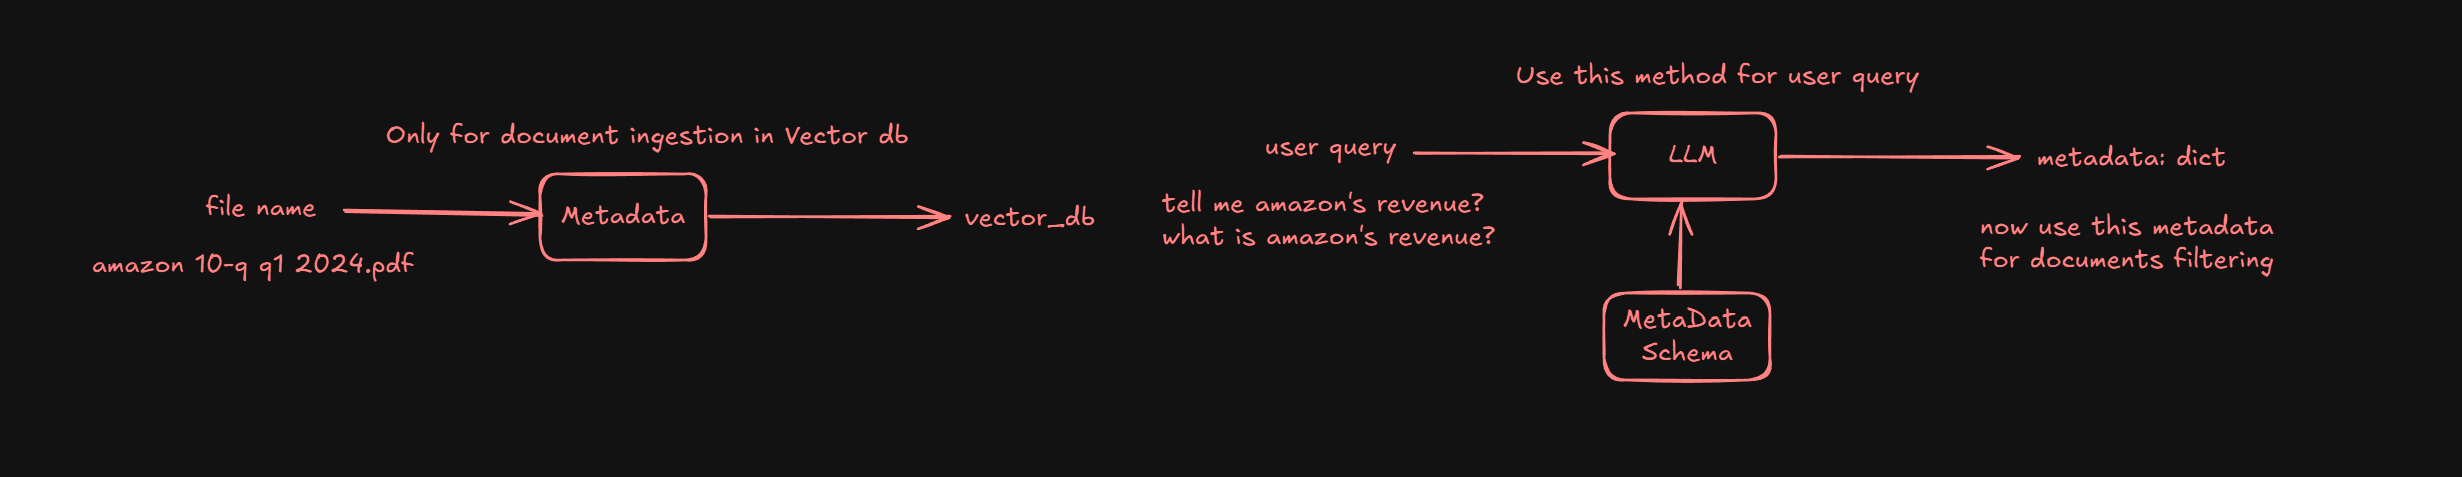

In [3]:
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_chroma import Chroma

from scripts.schemas import ChunkMetadata, RankingKeywords

In [4]:
# =============================================================================
# Configuration
# =============================================================================

# ChromaDB Configuration (from PageRAG - Data Ingestion)
CHROMA_DIR = "chroma_financial_db"
COLLECTION_NAME = "financial_docs"
EMBEDDING_MODEL = "nomic-embed-text"
BASE_URL = "http://localhost:11434"

LLM_MODEL = "qwen3"

In [5]:
# ollama pull nomic-embed_text
embeddings= OllamaEmbeddings(model=EMBEDDING_MODEL, base_url=BASE_URL)

vector_store = Chroma(
    collection_name=COLLECTION_NAME,
    embedding_function=embeddings,
    persist_directory=CHROMA_DIR
)

llm = ChatOllama(model=LLM_MODEL, base_url=BASE_URL)

llm.invoke("Hello, LangGraph and Ollama!")

AIMessage(content='Hello! It\'s great to see you\'re exploring **LangGraph** and **Ollama**! 🚀\n\n### What are they?\n- **LangGraph** is a framework for building applications with **large language models (LLMs)**, enabling you to create workflows, manage state, and chain together complex interactions with LLMs.\n- **Ollama** is a tool for **running and managing LLMs locally**, supporting models like Llama, Mistral, and more. It lets you run models without relying on cloud services.\n\n### How to Use Them Together\n1. **Install Ollama**:  \n   ```bash\n   curl -fsSL https://ollama.com/install.sh | sh\n   ```\n2. **Run a Model**:  \n   ```bash\n   ollama run llama3\n   ```\n3. **Use LangGraph**:  \n   Create workflows that interact with the locally running model via Ollama\'s API.\n\n### Example Workflow\n```python\nfrom langgraph import Graph\nfrom langgraph.nodes import Node\n\ndef query_model(prompt):\n    # Use Ollama to send the prompt to a local model\n    response = ollama.generat

### Extract Filters and Ranking Keywords

In [6]:
def extract_filters(user_query:str):

    llm_structured = llm.with_structured_output(ChunkMetadata)

    prompt = f"""Extract metadata filters from the query. Return None for fields not mentioned.

                USER QUERY: {user_query}

                COMPANY MAPPINGS:
                - Amazon/AMZN -> amazon
                - Google/Alphabet/GOOGL/GOOG -> google
                - Apple/AAPL -> apple
                - Microsoft/MSFT -> microsoft
                - Tesla/TSLA -> tesla
                - Nvidia/NVDA -> nvidia
                - Meta/Facebook/FB -> meta

                DOC TYPE:
                - Annual report -> 10-k
                - Quarterly report -> 10-q
                - Current report -> 8-k

                EXAMPLES:
                "Amazon Q3 2024 revenue" -> {{"company_name": "amazon", "doc_type": "10-q", "fiscal_year": 2024, "fiscal_quarter": "q3"}}
                "Apple 2023 annual report" -> {{"company_name": "apple", "doc_type": "10-k", "fiscal_year": 2023}}
                "Tesla profitability" -> {{"company_name": "tesla"}}

                Extract metadata:
                """
    
    metadata = llm_structured.invoke(prompt)
    filters = metadata.model_dump(exclude_none=True)

    return filters

In [7]:
extract_filters("what is google's revenue in 2024?")


{'company_name': 'google', 'fiscal_year': 2024}

### Generate Ranking Keywords

In [8]:
def generate_ranking_keywords(user_query: str):
    # ALT + Z
    prompt = f"""Generate EXACTLY 5 financial keywords from SEC filings terminology.

                USER QUERY: {user_query}

                USE EXACT TERMS FROM 10-K/10-Q FILINGS:

                STATEMENT HEADINGS:
                "consolidated statements of operations", "consolidated balance sheets", "consolidated statements of cash flows", "consolidated statements of stockholders equity"

                INCOME STATEMENT:
                "revenue", "net revenue", "cost of revenue", "gross profit", "operating income", "net income", "earnings per share"

                BALANCE SHEET:
                "total assets", "cash and cash equivalents", "total liabilities", "stockholders equity", "working capital", "long-term debt"

                CASH FLOWS:
                "cash flows from operating activities", "net cash provided by operating activities", "cash flows from investing activities", "free cash flow", "capital expenditures"

                RULES:
                - Return EXACTLY 5 keywords
                - Use exact phrases from SEC filings
                - Match query topic (revenue -> revenue terms, cash -> cash flow terms)
                - Use "cash flows" (plural), "stockholders equity"

                EXAMPLES:
                "revenue analysis" -> ["revenue", "net revenue", "total revenue", "consolidated statements of operations", "net sales"]
                "cash flow performance" -> ["consolidated statements of cash flows", "cash flows from operating activities", "net cash provided by operating activities", "free cash flow", "operating activities"]
                "balance sheet strength" -> ["consolidated balance sheets", "total assets", "stockholders equity", "cash and cash equivalents", "long-term debt"]

                Generate EXACTLY 5 keywords:
                """
    
    llm_structured = llm.with_structured_output(RankingKeywords)
    result = llm_structured.invoke(prompt)

    return result.keywords

In [9]:
generate_ranking_keywords("what is google's revenue in 2024?")

['revenue',
 'net revenue',
 'consolidated statements of operations',
 'gross profit',
 'operating income']

### Search the Doc from Vector DB

In [10]:
def build_search_kwargs(filters, ranking_keywords, k=3):

    search_kwargs = {"k": k, 'fetch_k': k*20}

    if filters:
        if len(filters) == 1:
            search_kwargs['filter'] = filters # filters = {'company_name': 'amazon'}

        else:
            # filters = {'company_name': 'amazon', 'doc_type':'10-k'}
            # [{'company_name': 'amazon'}, {'doc_type':'10-k'}]
            filters_conditions = [{k:v} for k, v in filters.items()]
            search_kwargs['filter'] = {"$and": filters_conditions}

    # Add document content filters using ranking keywords
    if ranking_keywords:
        if len(ranking_keywords) == 1:
            search_kwargs['where_document'] = {'$contains': ranking_keywords[0]}
        else:
            search_kwargs['where_document'] = {
                "$or": [{'$contains': keyword} for keyword in ranking_keywords]
            }

    return search_kwargs

In [11]:
def search_docs(query, filters={}, ranking_keywords=[], k=3):
    """
        Search documents with metadata and content filters.
        
        Args:
            query (str): Search query text
            filters (dict): Metadata filters (e.g., {"company_name": "amazon", "fiscal_year": 2023})
            ranking_keywords (list): Keywords for content filtering (documents must contain at least one)
            k (int): Number of results (default: 5)
        
        Returns:
            list: Matching Document objects
        
        Example:
            docs = search_docs(
                query="Analyze cash flow",
                filters={"company_name": "amazon", "doc_type": "10-k"},
                ranking_keywords=["cash flow", "liquidity"],
                k=10
            )
        """
    search_kwargs = build_search_kwargs(filters, ranking_keywords, k)

    retriever = vector_store.as_retriever(
        search_type= "mmr",
        search_kwargs = search_kwargs
    )

    return retriever.invoke(query)


In [12]:
query = "show ma amazon's cash flow in 2023"
results = search_docs(query)

In [13]:
results

[Document(id='ae4558dc-9ed4-48a6-93d3-e626e2459144', metadata={'company_name': 'amazon', 'doc_type': '10-q', 'source_file': 'amazon 10-q q2 2024.pdf', 'file_hash': '552615e47708aa125f69140f69d6bbd4c45f99981e4ed384f2d727d0665da8a8', 'fiscal_quarter': 'q2', 'fiscal_year': 2024, 'page': 31}, page_content="\n\n## Guidance\n\nWe provided guidance on August 1, 2024, in our earnings release furnished on Form 8-K as set forth below. These forward-looking statements reflect Amazon.com's expectations as of August 1, 2024, and are subject to substantial uncertainty. Our results are inherently unpredictable and may be materially affected by many factors, such as fluctuations in foreign exchange rates, changes in global economic and geopolitical conditions and customer demand and spending (including the impact of recessionary fears), inflation, interest rates, regional labor market constraints, world events, the rate of growth of the internet, online commerce, cloud services, and new and emerging t

In [27]:
query = "show ma amazon's cash flow in 2023"
filters = extract_filters(query)
ranking_keywords = generate_ranking_keywords(query)

results = search_docs(query, filters, ranking_keywords, k=20)

In [28]:
results

[Document(id='2e38b407-bee5-4362-8305-ea2e79dd88a9', metadata={'doc_type': '10-k', 'page': 42, 'file_hash': '6e5549c7b20b0fbc5f482397070a1e85cbf8643c801ff570903f52366b11154f', 'fiscal_year': 2023, 'company_name': 'amazon', 'source_file': 'amazon 10-k 2023.pdf'}, page_content="\n\n## AMAZON.COM, INC. NOTES TO CONSOLIDATED FINANCIAL STATEMENTS\n\n## Note 1 - DESCRIPTION OF BUSINESS, ACCOUNTING POLICIES, AND SUPPLEMENTAL DISCLOSURES\n\n## Description of Business\n\nWe seek to be Earth's most customer-centric company. In each of our segments, we serve our primary customer sets, consisting of consumers, sellers, developers, enterprises, content creators, advertisers, and employees. We serve consumers through our online and physical stores and focus on selection, price, and convenience. We offer programs that enable sellers to grow their businesses, sell their products in our stores, and fulfill orders using our services, and programs that allow authors, independent publishers, musicians, fi

In [26]:
ranking_keywords

['consolidated statements of cash flows',
 'cash flows from operating activities',
 'net cash provided by operating activities',
 'free cash flow',
 'capital expenditures']

### Extract Documents Headings and Sub-Headings for ReRanking

In [29]:
import re

def extract_headings_with_content(text):
    """
    Extract markdown headings with one paragraph of content after them.
    
    Args:
        text: Document text content
    
    Returns:
        List of extracted heading + content chunks
    """

    chunks = []

    sections = text.split('\n\n')

    i = 0
    while i< len(sections):
        section = sections[i].strip()

        pattern = r"^#+\s+"
        if re.match(pattern, section):
            heading = section

            # Get the next paragraph/content after the heading
            if i+1 < len(sections):
                next_content = sections[i+1].strip()

                chunk = f"{heading}\n\n{next_content}"
                i = i + 2
            
            else:
                chunk = heading
                i = i + 1

            chunks.append(chunk)

        else:
            i = i + 1

    return chunks



In [31]:
heading_content = extract_headings_with_content(results[2].page_content)

In [32]:
heading_content

['## Interest Income and Expense\n\nOur interest income was $989 million and $2.9 billion during 2022 and 2023, primarily due to an increase in prevailing rates. We generally invest our excess cash in AAA-rated money market funds and investment grade short- to intermediate-term marketable debt securities. Our interest income corresponds with the average balance of invested funds based on the prevailing rates, which vary depending on the geographies and currencies in which they are invested.',
 '## Other Income (Expense), Net\n\nOther income (expense), net was $(16.8) billion and $938 million during 2022 and 2023. The primary components of other income (expense), net are related to equity securities valuations and adjustments, equity warrant valuations, and foreign currency. Included in other income (expense), net in 2022 and 2023 is a marketable equity securities valuation gain (loss) of $(12.7) billion and $797 million from our equity investment in Rivian.',
 '## Income Taxes\n\nOur e

In [34]:
ranking_keywords

['consolidated statements of cash flows',
 'cash flows from operating activities',
 'net cash provided by operating activities',
 'free cash flow',
 'capital expenditures']

### Rank documents using BM25Plus

In [38]:
from rank_bm25 import BM25Plus

# https://pypi.org/project/rank-bm25/
def rank_documents_by_keywords(docs, keywords, k=5):
    # 5 -> 20 retriever -> mmr 20*20
    """
    Rank documents using BM25Plus on heading+content chunks.
    
    Args:
        docs: List of Document objects to rank
        keywords: List of keywords to rank by
        k: Number of top documents to return
    
    Returns:
        List of top-k Document objects sorted by BM25 score
    """

    if not docs or not keywords:
        print("Either No doc or keywords found!")
        return docs
    
    query_tokens = " ".join(keywords).lower().split(" ")

    # extract chunks for each document
    doc_chunks = []
    for doc in docs:
        chunks = extract_headings_with_content(doc.page_content)

        combined = " ".join(chunks) if chunks else doc.page_content

        doc_chunks.append(combined.lower().split(' '))

    # Rank using BM25Plust

    bm25 = BM25Plus(doc_chunks)
    doc_scores = bm25.get_scores(query_tokens)

    ranked_indices = sorted(range(len(doc_scores)), key=lambda i: doc_scores[i], reverse=True)

    for rank, idx in enumerate(ranked_indices[:k], 1):
        print(f"   [{rank}] Doc {idx}: score={doc_scores[idx]:.4f}")


    return [docs[i] for i in ranked_indices[:k]]

In [36]:
corpus = [
    "Hello there good man!",
    "It is quite windy in London",
    "How is the weather today?"
]

[doc.split(" ") for doc in corpus]

[['Hello', 'there', 'good', 'man!'],
 ['It', 'is', 'quite', 'windy', 'in', 'London'],
 ['How', 'is', 'the', 'weather', 'today?']]

In [35]:
results

[Document(id='2e38b407-bee5-4362-8305-ea2e79dd88a9', metadata={'doc_type': '10-k', 'page': 42, 'file_hash': '6e5549c7b20b0fbc5f482397070a1e85cbf8643c801ff570903f52366b11154f', 'fiscal_year': 2023, 'company_name': 'amazon', 'source_file': 'amazon 10-k 2023.pdf'}, page_content="\n\n## AMAZON.COM, INC. NOTES TO CONSOLIDATED FINANCIAL STATEMENTS\n\n## Note 1 - DESCRIPTION OF BUSINESS, ACCOUNTING POLICIES, AND SUPPLEMENTAL DISCLOSURES\n\n## Description of Business\n\nWe seek to be Earth's most customer-centric company. In each of our segments, we serve our primary customer sets, consisting of consumers, sellers, developers, enterprises, content creators, advertisers, and employees. We serve consumers through our online and physical stores and focus on selection, price, and convenience. We offer programs that enable sellers to grow their businesses, sell their products in our stores, and fulfill orders using our services, and programs that allow authors, independent publishers, musicians, fi

In [39]:
reranked_results = rank_documents_by_keywords(results, ranking_keywords)

   [1] Doc 7: score=42.6832
   [2] Doc 2: score=37.5842
   [3] Doc 1: score=36.8413
   [4] Doc 3: score=33.8716
   [5] Doc 0: score=28.4184


In [40]:
reranked_results

[Document(id='1e8e00e2-4573-4433-9eb7-4b287bbf7c38', metadata={'source_file': 'amazon 10-k 2023.pdf', 'fiscal_year': 2023, 'page': 23, 'file_hash': '6e5549c7b20b0fbc5f482397070a1e85cbf8643c801ff570903f52366b11154f', 'doc_type': '10-k', 'company_name': 'amazon'}, page_content="\n\nacquisitions, investments in other companies and intellectual property rights, and purchases, sales, and maturities of marketable securities. Cash provided by (used in) investing activities was $(37.6) billion and $(49.8) billion in 2022 and 2023, with the variability caused primarily by purchases, sales, and maturities of marketable securities and cash capital expenditures. Cash capital expenditures were $58.3 billion, and $48.1 billion in 2022 and 2023, which primarily reflect investments in technology infrastructure (the majority of which is to support AWS business growth) and in additional capacity to support our fulfillment network, which investments we expect to increase in 2024. We made cash payments, n

In [42]:
ranking_keywords

['consolidated statements of cash flows',
 'cash flows from operating activities',
 'net cash provided by operating activities',
 'free cash flow',
 'capital expenditures']